## On-Policy 和 Off-Policy
- On-Policy： 你用什么策略收集数据，就学习并改进这个策略。
- Off-Policy： 学习的是另一个target policy的价值。即：你用一种策略收集经验，但希望学到另一种（通常更优的）策略。
## Q-Learning
- 关键性质
    - **Off-policy**：有两个策略：
        - behaviour policy（ϵ-greedy）：用于探索所有state-action pair 的 action value
        - target policy (贪婪的) ：根据behaviour policy探索得到的所有action value，总结出的optimal policy
    - **bootstrapping**：用action value来代替state value
    - **收敛性**：在所有state-action pair被无限次访问且 α 满足 Robbins–Monro 条件时，假设的action value会收敛到TD target
    - 与 SARSA 的区别：
        - SARSA: 解决Bellman Equation: 用 **Q(s′,a′)**（按behaviour policy采样）作为TD target
        - Q-Learning: 解决Bellman optimality Equantion: 用 **MAX𝑎′ 𝑄(𝑠′,𝑎′)** （按behaviour policy采样）作为TD target
    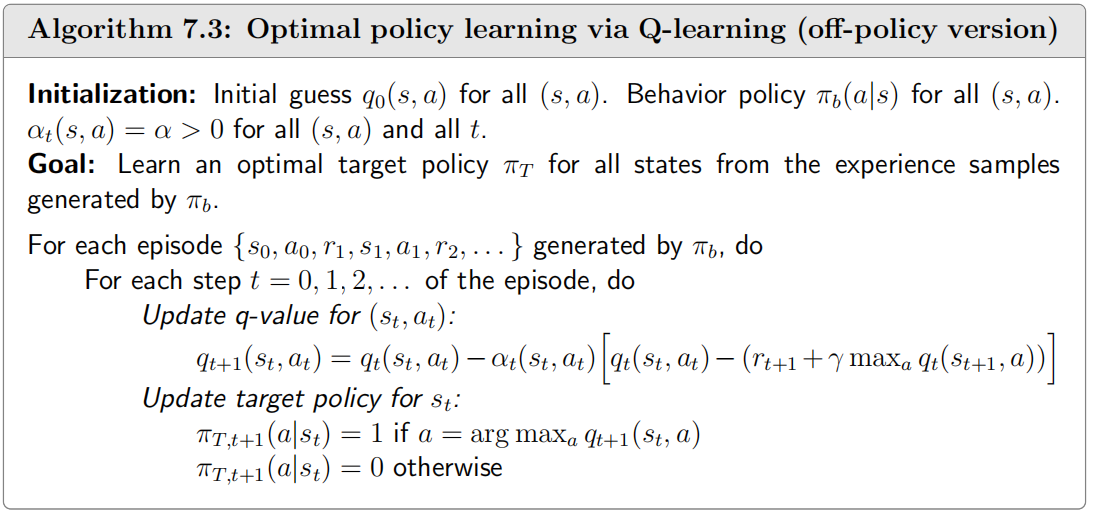
    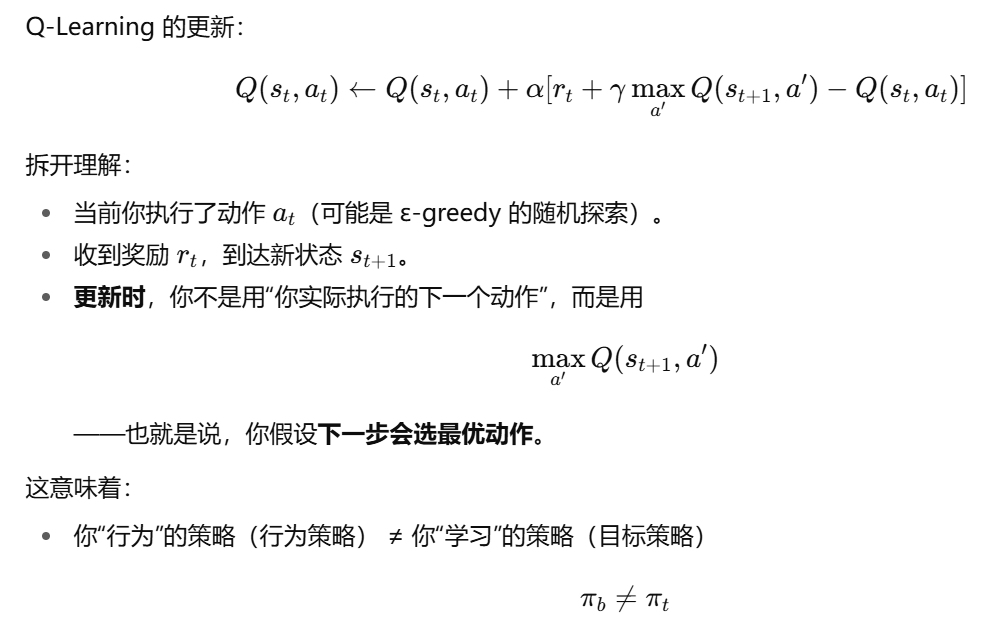

## Q-Learning 和 Sarsa Learning的比较：
- 在我设计的GirdWorld中：
    - Sarsa： 表现十分稳定，总能找到到goal state的路线
    - Q-Learning: 表现十分不稳定，有时候能找到路线，有时候不能，这是因为它假设下一步能选到“理论最优动作”，但实际上你可能因为随机偏移或探索没做到那一步。会引入一种叫做 optimistic bias（过度乐观偏差）。
- 所以Saras适合    不稳定的环境，    结果可控但是速度慢
- Q-Learning适合   稳定的环境，     结果方差大，但是速度快

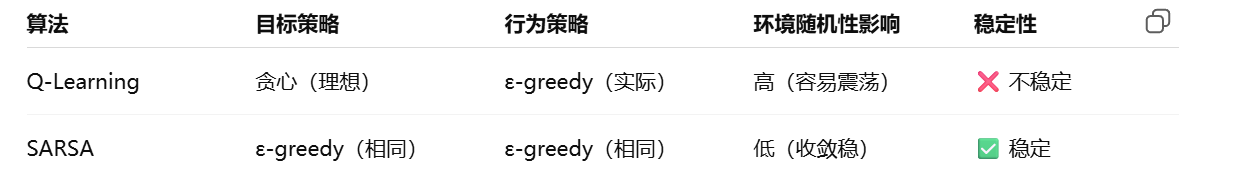

In [263]:
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(19)

class GridWorld:
    def __init__(self, rows=7, cols=7, goal=(5,5), reward= -1, start=(0,0), forbidden=[(1,4),(2,3),(2,2),(3,3),(4,5),(5,4),(5,6)]):
        self.rows = rows
        self.cols = cols
        self.start = start
        self.goal = goal
        self.reward = reward
        self.forbidden = set(forbidden)
        self.actions = {
            0: (-1, 0),  # up
            1: (0, 1),   # right
            2: (1, 0),   # down
            3: (0, -1),   # left
            4: (0, 0)    # stay
        }

        self.left_map = {0:3, 1:0, 2:1, 3:2, 4:4}   # 左转90°
        self.right_map = {0:1, 1:2, 2:3, 3:0, 4:4}  # 右转90°

    def step(self, state, action):
        """输入 state=(r,c), action，返回 (next_state, reward)"""
        r, c = state

        # 随机转移
        if action == 4:
            dr, dc = self.actions[action]
        else:
            prob = np.random.rand()
            if prob < 0.1:   # 左偏
                action = self.left_map[action]
            elif prob < 0.2: # 右偏
                action = self.right_map[action]
            # 其余 80% 保持不变
            dr, dc = self.actions[action]

        new_r, new_c = r + dr, c + dc

        # 撞墙，移动惩罚，额外惩罚10点
        if not (0 <= new_r < self.rows and 0 <= new_c < self.cols):
            return state, -5 + self.reward

        # 禁区，额外移动惩罚，额外惩罚10点
        if (new_r, new_c) in self.forbidden:
            return (new_r, new_c), -10 + self.reward

        # 到达目标，移动惩罚，额外奖励50点
        if (new_r, new_c) == self.goal:
            return (new_r, new_c), 50 + self.reward

        # 普通移动惩罚
        return (new_r, new_c), 0 + self.reward
    
    def get_states(self):
        """返回所有可用状态"""
        states = []
        for r in range(self.rows):
            for c in range(self.cols):
                states.append((r, c))
        return states
    
    
    def render(self, policy=None, values=None, cell_size=1.2, show_path=True):
        """可视化：白色=正常, 黄=禁区, 蓝=goal, 灰=起点, 红线=路径"""
        fig, ax = plt.subplots(figsize=(self.cols * cell_size, self.rows * cell_size))

        # ---- 绘制格子背景 ----
        grid = np.ones((self.rows, self.cols, 3))  # 默认白色
        for (r, c) in self.forbidden:
            grid[r, c] = [1, 1, 0]  # 黄色
        gr, gc = self.goal
        grid[gr, gc] = [0, 0, 1]  # 蓝色
        sr, sc = self.start
        grid[sr, sc] = [0.5, 0.5, 0.5]  # 灰色表示起点

        ax.imshow(grid, origin="upper")

        # ---- 显示值函数 ----
        if values is not None:
            for (r, c), v in values.items():
                ax.text(c, r + 0.25, f"{v:.1f}", ha='center', va='top', color='black', fontsize=12)

        # ---- 显示策略箭头 ----
        if policy is not None:
            arrows = {0: "↑", 1: "→", 2: "↓", 3: "←", 4: "O"}
            for (r, c), a in policy.items():
                ax.text(c, r - 0.2, arrows[a], ha='center', va='center', color='red', fontsize=16, fontweight='bold')

        # ---- 绘制路径（按策略从 start -> goal） ----
        if policy is not None and show_path:
            path = [self.start]
            state = self.start
            visited = set()
            for _ in range(1000):  # 防止死循环
                if state == self.goal:
                    break
                if state in visited:
                    break
                visited.add(state)
                action = policy.get(state, 4)
                dr, dc = self.actions[action]
                next_state = (state[0] + dr, state[1] + dc)
                if next_state not in self.get_states():  # 越界
                    break
                path.append(next_state)
                state = next_state

            # 绘制红线路径（注意行列转为 x,y）
            xs = [c for r, c in path]
            ys = [r for r, c in path]
            ax.plot(xs, ys, color='red', linewidth=2, marker='o', markersize=6, alpha=0.8)

        # ---- 网格与样式 ----
        ax.set_xticks(np.arange(-0.5, self.cols, 1))
        ax.set_yticks(np.arange(-0.5, self.rows, 1))
        ax.grid(which="both", color="black", linewidth=1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()


In [264]:
def epsilon_greedy(Q, state, actions, eps=0.1):
    """epsilon-greedy策略"""
    best_action = max(actions.keys(), key=lambda a: Q[(state, a)])  
    if np.random.rand() < eps:
        return np.random.choice(list(actions.keys()))  # 随机探索
    else:
        return best_action  # 利用

In [265]:
def argmax_tie_break(q_dict, state, actions):
    vals = [(a, q_dict[(state,a)]) for a in actions]
    m = max(v for _, v in vals)
    cands = [a for a, v in vals if v == m]
    return random.choice(cands)

In [266]:
def Q_Learning (env, episodes=500, alpha=0.1, gamma=0.9, eps=0.1):
    # 初始化
    policy_target = {s: 0 for s in env.get_states() }
    Q = {(s,a):0.0 for s in env.get_states() for a in env.actions.keys()}
    Total_rewards = []  # 每个episode总奖励
    Episode_lengths = []  # 每个episode的长度

    # 开始训练
    for episode in range(episodes):
        eps0, decay, eps_min = 1.0, 0.995, 0.05
        eps = max(eps_min, eps0 * (decay ** episode))  # eps衰减

        
        total_reward = 0 # 该episode总奖励
        step = 0 # 该episode步数

        # 生成episode链，直到goal state
        valid_states = [s for s in env.get_states() if s != env.goal and s not in env.forbidden]
        state = random.choice(valid_states) # 随机生成一个start state

        while state != env.goal:
            action = epsilon_greedy(Q, state, env.actions, eps) # 使用ε-greedy选择policy behaviour
            next_state, next_reward = env.step(state, action)  # 基于Q-Learning Off-policy性质，使用policy behaviour和环境交互
            best_next_action = argmax_tie_break(Q, next_state, env.actions.keys()) # 基于Q-Learning Off-policy性质，使用最佳action更新Q值

            Q[(state,action)] = Q[(state,action)] - alpha * (Q[(state,action)] - (next_reward + gamma * Q[(next_state,best_next_action)])) # update Q-value
            policy_target[state] = argmax_tie_break(Q, state, env.actions.keys()) # update target policy

            step += 1 # 更新记录
            total_reward += next_reward # 更新记录

            state = next_state  # 准备下一个循环

            # 防止死循环
            if step > 1000: 
                break
        
        Total_rewards.append(total_reward)
        Episode_lengths.append(step)

    # 训练结束后，构建最终的 values 供渲染/评估
    values = {}
    for s in env.get_states():
        values[s] = max(Q[(s, a)] for a in env.actions.keys())

    return values, policy_target, Total_rewards, Episode_lengths

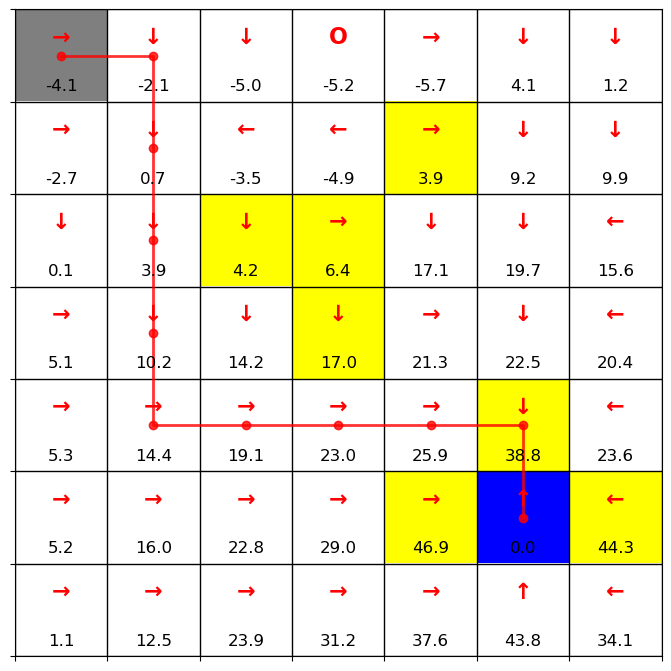

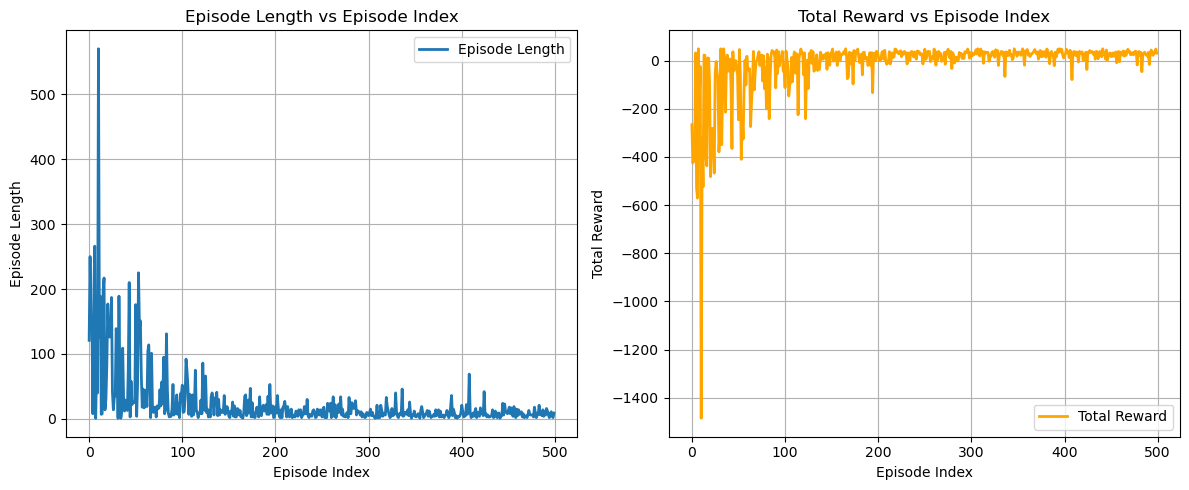

In [267]:
# 运行
env = GridWorld()

# 开始训练
values, policy, Total_rewards, Episode_lengths = Q_Learning(env, episodes=500, alpha=0.1, gamma=0.9, eps=1)
env.render(policy, values)

# 画出效果图
plt.figure(figsize=(12, 5))
episodes = list(range(len(Episode_lengths)))
# ---- 图1：Episode Length ----
plt.subplot(1, 2, 1)
plt.plot(episodes, Episode_lengths, label='Episode Length', linewidth=2)
plt.xlabel('Episode Index')
plt.ylabel('Episode Length')
plt.title('Episode Length vs Episode Index')
plt.grid(True)
plt.legend()

# ---- 图2：Total Reward ----
plt.subplot(1, 2, 2)
plt.plot(episodes, Total_rewards, color='orange', label='Total Reward', linewidth=2)
plt.xlabel('Episode Index')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode Index')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()